In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster, datasets
from sklearn.cross_validation import train_test_split
%matplotlib inline

/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Train and predict categories for all crime types:

In [2]:
#load train
train = pd.read_csv('/home/ubuntu/Notebooks/SFCRIME/input/SFPD_CRIME.csv', parse_dates=['Date','Time'])

In [3]:
train['Year'] = train['Date'].apply(lambda x: x.strftime('%Y'))
train['Hour'] = train['Time'].apply(lambda x: x.hour)
train['Week'] = train['Date'].apply(lambda x:x.week)
train['Month'] = train['Date'].apply(lambda x:x.month)
train['day'] = train['Date'].apply(lambda x:x.day)
train['week_number'] = pd.to_datetime(train['Date'], format="%m/%d/%Y").apply(lambda x: x.isocalendar()[1])

In [4]:
# train['Year'] = train['Dates'].apply(lambda x: x.strftime('%Y'))
# train['Hour'] = train['Dates'].apply(lambda x: x.hour)
# train['Week'] = train['Dates'].apply(lambda x:x.week)
# train['Month'] = train['Dates'].apply(lambda x:x.month)
# train['day'] = train['Dates'].apply(lambda x:x.day)
# train['week_number'] = pd.to_datetime(train['Dates'], format="%m/%d/%Y").apply(lambda x: x.isocalendar()[1])

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2024579 entries, 0 to 2024578
Data columns (total 19 columns):
IncidntNum     int64
Category       object
Descript       object
DayOfWeek      object
Date           datetime64[ns]
Time           datetime64[ns]
PdDistrict     object
Resolution     object
Address        object
X              float64
Y              float64
Location       object
PdId           int64
Year           object
Hour           int64
Week           int64
Month          int64
day            int64
week_number    int64
dtypes: datetime64[ns](2), float64(2), int64(7), object(8)
memory usage: 293.5+ MB


In [6]:
set(train['Category'])

{'ARSON',
 'ASSAULT',
 'BAD CHECKS',
 'BRIBERY',
 'BURGLARY',
 'DISORDERLY CONDUCT',
 'DRIVING UNDER THE INFLUENCE',
 'DRUG/NARCOTIC',
 'DRUNKENNESS',
 'EMBEZZLEMENT',
 'EXTORTION',
 'FAMILY OFFENSES',
 'FORGERY/COUNTERFEITING',
 'FRAUD',
 'GAMBLING',
 'KIDNAPPING',
 'LARCENY/THEFT',
 'LIQUOR LAWS',
 'LOITERING',
 'MISSING PERSON',
 'NON-CRIMINAL',
 'OTHER OFFENSES',
 'PORNOGRAPHY/OBSCENE MAT',
 'PROSTITUTION',
 'RECOVERED VEHICLE',
 'ROBBERY',
 'RUNAWAY',
 'SECONDARY CODES',
 'SEX OFFENSES, FORCIBLE',
 'SEX OFFENSES, NON FORCIBLE',
 'STOLEN PROPERTY',
 'SUICIDE',
 'SUSPICIOUS OCC',
 'TREA',
 'TRESPASS',
 'VANDALISM',
 'VEHICLE THEFT',
 'WARRANTS',
 'WEAPON LAWS'}

Too many categories, I'll have to manually pair them down.

In [7]:
violent = ['ASSAULT','SEX OFFENSES FORCIBLE','SEX OFFENSES NON FORCIBLE','ROBBERY','KIDNAPPING']

non_violent = ['SUICIDE','SUSPICIOUS OCC','LARCENY/THEFT','DRUNKENNESS','DRIVING UNDER THE INFLUENCE','DISORDERLY CONDUCT']

property_ = ['VANDALISM','VEHICLE THEFT','TRESPASS','STOLEN PROPERTY','RECOVERED VEHICLE','ARSON','BURGLARY',]

other = ['NON-CRIMINAL','SECONDARY CODES','RUNAWAY','OTHER OFFENSES', 'MISSING PERSON','LOITERING','TREA']

illegal = ['GAMBLING','DRUG/NARCOTIC','WARRANTS','PORNOGRAPHY/OBSCENE MAT','LIQUOR LAWS','FRAUD','FAMILY OFFENSES','WEAPON LAWS']

criminal_acts = ['EMBEZZLEMENT','BAD CHECKS','BRIBERY','PROSTITUTION','EXTORTION','FORGERY/COUNTERFEITING']

len(violent)+len(non_violent)+len(property_)+len(other)+len(illegal)+len(criminal_acts)

39

In [8]:
for v in violent:
    train.loc[train['Category']==v,'Category']='violent'
for v in non_violent:
    train.loc[train['Category']==v,'Category']='non_violent'
for v in property_:
    train.loc[train['Category']==v,'Category']='property_'
for v in other:
    train.loc[train['Category']==v,'Category']='other'
for v in illegal:
    train.loc[train['Category']==v,'Category']='illegal'
for v in criminal_acts:
    train.loc[train['Category']==v,'Category']='criminal_acts'

## Now there are only six categories, too many...


## Look at only three catagories...

In [9]:
three_data = train[(train['Category']=='violent') | (train['Category']=='non_violent') |(train['Category']=='property_')]

## Plot training data

In [10]:
three_data.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId,Year,Hour,Week,Month,day,week_number
1,150098210,violent,"ROBBERY, BODILY FORCE",Sunday,2015-02-01,2017-02-21 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821003074,2015,15,5,2,1,5
2,150098210,violent,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,2015-02-01,2017-02-21 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,"(37.7841907151119, -122.414406029855)",15009821004014,2015,15,5,2,1,5
4,150098226,property_,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Tuesday,2015-01-27,2017-02-21 19:00:00,NORTHERN,NONE,LOMBARD ST / LAGUNA ST,-122.431119,37.800469,"(37.8004687042875, -122.431118543788)",15009822628160,2015,19,5,1,27,5
7,150098248,property_,"MALICIOUS MISCHIEF, VANDALISM",Saturday,2015-01-31,2017-02-21 21:00:00,BAYVIEW,NONE,700 Block of KIRKWOOD AV,-122.374019,37.729203,"(37.729203356539, -122.374019331833)",15009824828150,2015,21,5,1,31,5
8,150098254,property_,"BURGLARY OF STORE, UNLAWFUL ENTRY",Saturday,2015-01-31,2017-02-21 16:09:00,CENTRAL,NONE,200 Block of STOCKTON ST,-122.406568,37.787809,"(37.7878092959561, -122.40656817787)",15009825405053,2015,16,5,1,31,5


/home/ubuntu/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/

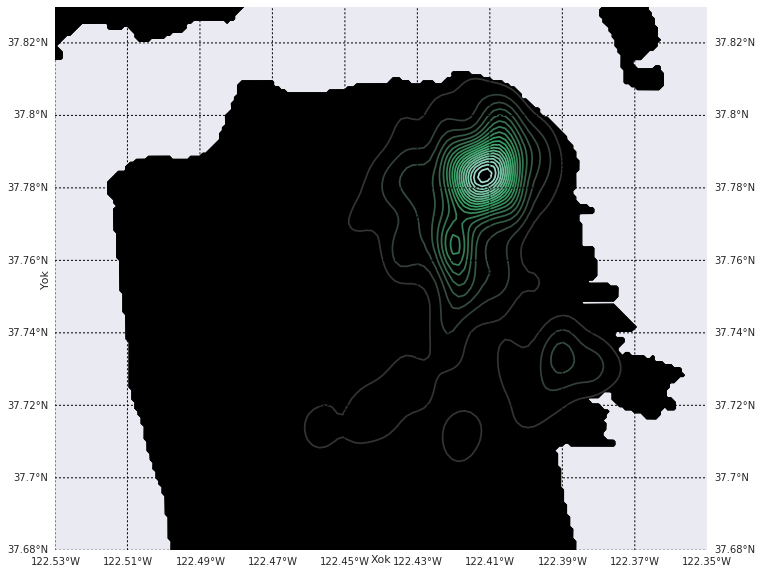

In [11]:
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as pl
import numpy as np
import seaborn as sns
import zipfile
pl.figure(figsize=(20,10))
map_extent = [-122.53, 37.68, -122.35, 37.83]
m = Basemap(llcrnrlon=map_extent[0], llcrnrlat=map_extent[1],
             urcrnrlon=map_extent[2], urcrnrlat=map_extent[3],projection='lcc',resolution='f', epsg=4269)
m.drawcoastlines()
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color = 'black')
longitudes = np.arange(-122.53, -122.35, .02)
latitudes = np.arange(37.68, 37.83, .02)
m.drawparallels(latitudes,labels=[1,1,0,0])
m.drawmeridians(longitudes,labels=[0,0,0,1])
asp = 1
lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)
clipsize = [[-122.5247, -122.3366],[ 37.699, 37.8299]]

three_data['Xok'] = three_data[three_data.X<-122].X
three_data['Yok'] =three_data[three_data.Y<40].Y
three_data = three_data.dropna()
train_cat = three_data[three_data.Category == 'violent'] 
train_cat = train_cat[1:3000] #Can't use all the data and complete within 600 sec :(
ax = sns.kdeplot(train_cat.Xok, train_cat.Yok,n_levels=20, clip=clipsize, aspect=1/asp)
ax= pl.gca()
pl.show()

## Explore Data

In [12]:
three_data['Category'].value_counts()

non_violent    520871
property_      348122
violent        234239
Name: Category, dtype: int64

In [13]:
three_data['count'] = 1

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


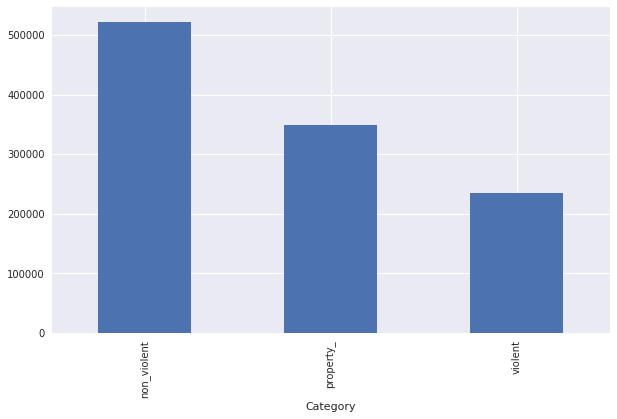

In [14]:
three_data.groupby(['Category'])['count'].sum().plot(kind = 'bar',figsize = (10,6))

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


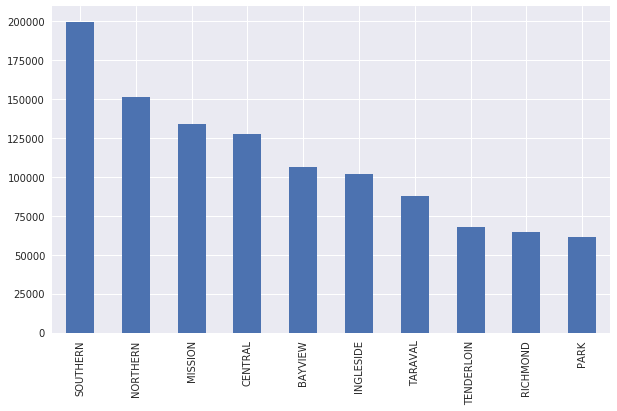

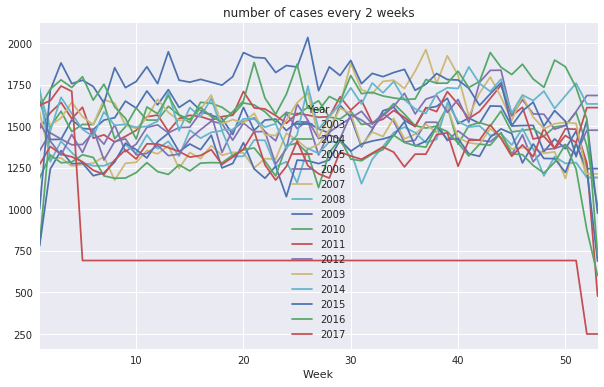

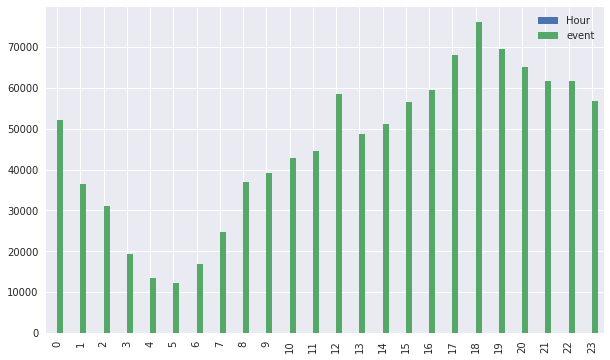

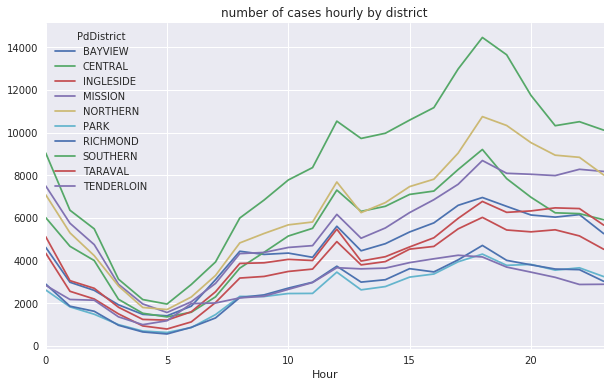

In [15]:
three_data.PdDistrict.value_counts().plot(kind='bar', figsize=(10,6))
three_data['event']=1
weekly_events = three_data[['Week','Year','event']].groupby(['Year','Week']).count().reset_index()
weekly_events_years = weekly_events.pivot(index='Week', columns='Year', values='event').fillna(method='ffill')
#%matplotlib inline'
ax = weekly_events_years.interpolate().plot(title='number of cases every 2 weeks', figsize=(10,6))

hourly_events = three_data[['Hour','event']].groupby(['Hour']).count().reset_index()
hourly_events.plot(kind='bar', figsize=(10, 6))

hourly_district_events = three_data[['PdDistrict','Hour','event']].groupby(['PdDistrict','Hour']).count().reset_index()
hourly_district_events_pivot = hourly_district_events.pivot(index='Hour', columns='PdDistrict', values='event').fillna(method='ffill')
hourly_district_events_pivot.interpolate().plot(title='number of cases hourly by district', figsize=(10,6))

## Predict Crimes

In [16]:
# from sklearn import datasets
# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.svm import LinearSVC

# pred = OneVsRestClassifier(LinearSVC(random_state=0)).fit(X_train, y_train).predict(X_test)
# from sklearn.metrics import accuracy_score,f1_score
# print(accuracy_score(y_test, pred))
# f1_score(y_test,pred,average= 'weighted')

In [17]:
# from sklearn.metrics import accuracy_score,f1_score
# #select features...
# #select target...
# X = train[['X', 'Y','Week','Hour','day']]
# y = train['Category']
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=5)
# kf.get_n_splits(X)
# f1_folds = []
# print(kf)  
# for train_index, test_index in kf.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y[train_index], y[test_index]
    
#     xgb = xgboost.XGBClassifier(learning_rate=0.01,max_depth=7,missing=None, n_estimators=100, nthread=-1)
#     xgb.fit(X_train,y_train)
#     y_pred = xgb.predict(X_test)
#     print(accuracy_score(y_test, y_pred))
#     f1_folds.append(f1_score(y_test,y_pred,average = 'weighted'))
    
# print(np.mean(f1_folds))

In [18]:
# from sklearn.ensemble import GradientBoostingClassifier
# gnbc = GradientBoostingClassifier(learning_rate=0.1,n_estimators=5,
#                                   min_samples_split=2,min_samples_leaf=1,max_depth=12)
# gnbc.fit(X_train,y_train)
# predicted = gnbc.predict(X_test)

In [19]:
# from sklearn.neighbors import KNeighborsClassifier
# neigh = KNeighborsClassifier(n_neighbors=14)
# neigh.fit(X_train_pca, y_train) 
# print(classification_report(y_test, neigh.predict(X_test_pca)))

In [20]:
X = three_data[['X', 'Y','Hour','day']]
y = three_data['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
import xgboost
xgb = xgboost.XGBClassifier(learning_rate=0.001,max_depth=7,missing=None, n_estimators=400, nthread=-1)
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.001, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=400, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [22]:
# make predictions for test data
y_pred = xgb.predict(X_test)
y_proba= xgb.predict_proba(X_test)

In [23]:
from sklearn.metrics import roc_auc_score, classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

non_violent       0.53      0.82      0.65    156205
  property_       0.44      0.32      0.37    104706
    violent       0.43      0.08      0.14     70059

avg / total       0.48      0.51      0.45    330970



In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)

array([[128379,  23736,   4090],
       [ 67567,  33530,   3609],
       [ 45411,  18767,   5881]])

In [25]:
from sklearn.metrics import accuracy_score,f1_score
print(accuracy_score(y_test, y_pred))
f1_score(y_test,y_pred,average= 'weighted')

0.506964377436


0.45195533787872955

# Plot Crime predictions

/home/ubuntu/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


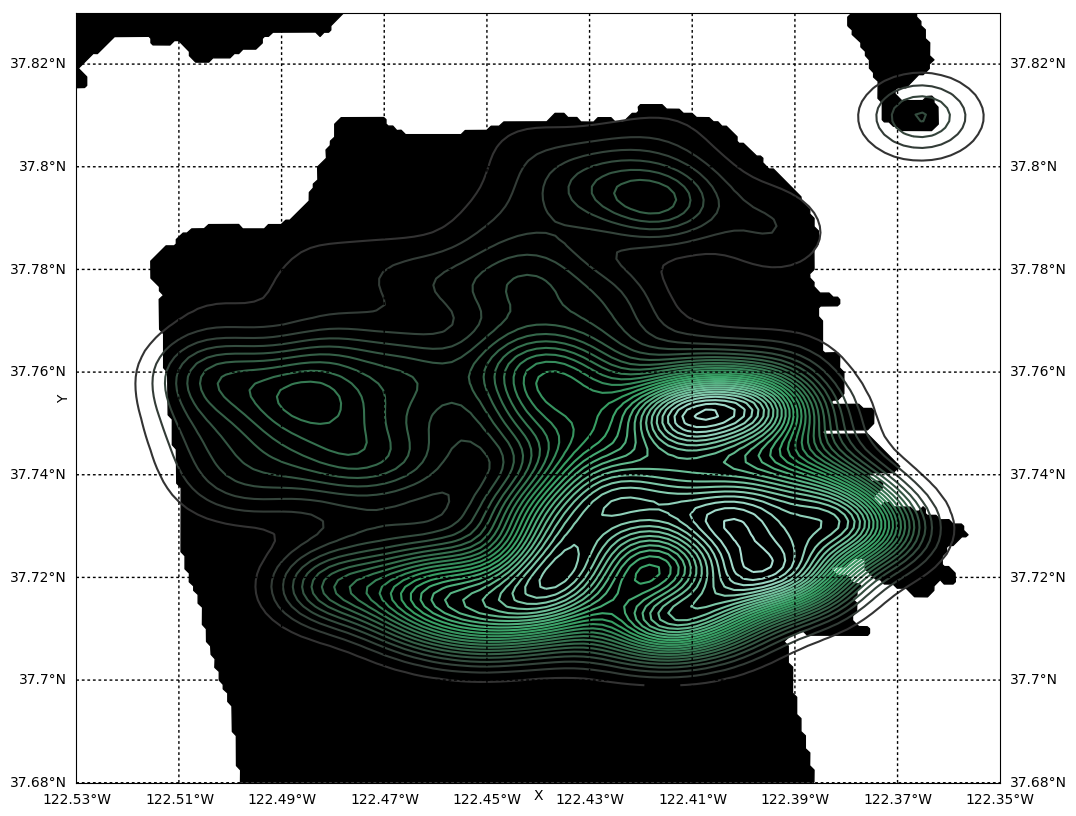

In [84]:
from mpl_toolkits.basemap import Basemap
plt.figure(figsize=(20,10))
longitudes = np.arange(-122.53, -122.35, .02)
latitudes = np.arange(37.68, 37.83, .02)
map_extent = [-122.53, 37.68, -122.35, 37.83]
m = Basemap(llcrnrlon=map_extent[0], llcrnrlat=map_extent[1],
             urcrnrlon=map_extent[2], urcrnrlat=map_extent[3],projection='lcc',resolution='f', epsg=4269)
m.fillcontinents(color = 'black')
m.drawstates()
m.drawcoastlines()
m.drawcountries()
m.drawparallels(latitudes,labels=[1,1,0,0])
m.drawmeridians(longitudes,labels=[0,0,0,1])
clipsize = [[-122.5247, -122.3366],[ 37.699, 37.8299]]
test_cat = X_test[y_pred== 'property_'] 
Xok = test_cat.X[0:2000]
Yok = test_cat.Y[0:2000]
test_cat = test_cat.dropna()
asp =1
ax = sns.kdeplot(Xok, Yok,n_levels=30, clip=clipsize, aspect=1/asp)
ax = plt.gca()
plt.show()

## ROC CURVE

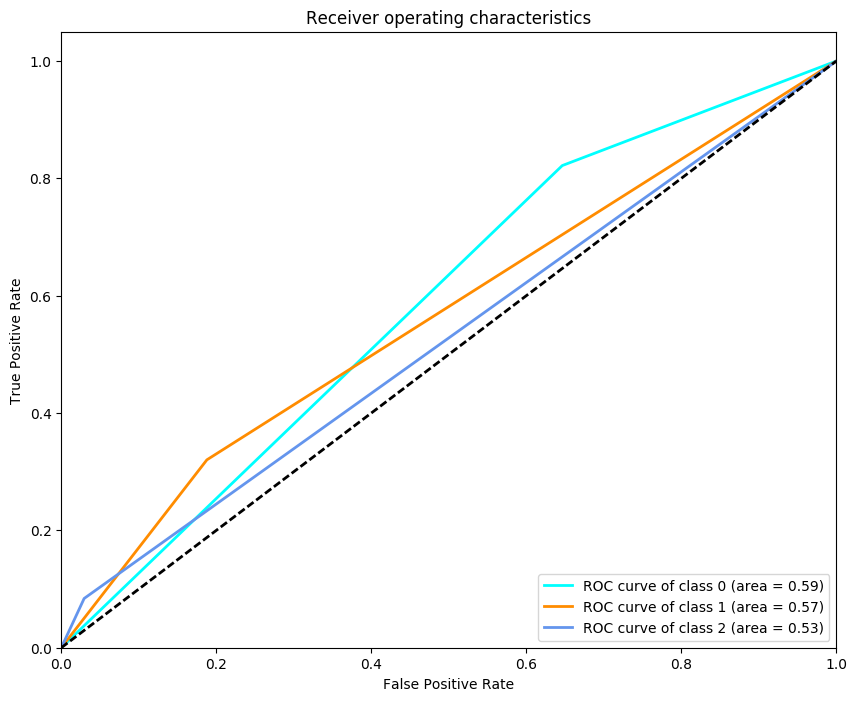

In [49]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm, datasets
from sklearn.metrics import roc_curve,auc
from itertools import cycle
lw = 2
plt.figure(figsize = (10,8))
y_test_2 = pd.get_dummies(y_test)
y_score = pd.get_dummies(y_pred)
n_classes = len(set(y_pred))
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_2.iloc[:, i], y_score.iloc[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristics')
plt.legend(loc="lower right")
plt.show()

In [31]:
(.59+.57+.54) /3

0.5666666666666667

In [50]:
y_test_2

,non_violent,property_,violent
490017,0.0,1.0,0.0
1722355,1.0,0.0,0.0
848123,0.0,1.0,0.0
987858,0.0,1.0,0.0
1935381,0.0,1.0,0.0
1590854,1.0,0.0,0.0
61644,0.0,1.0,0.0
1823982,1.0,0.0,0.0
557756,1.0,0.0,0.0
297901,0.0,1.0,0.0


## Precision-Recall Curve

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from itertools import cycle

# from sklearn import svm, datasets
# from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import average_precision_score
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import label_binarize
# from sklearn.multiclass import OneVsRestClassifier
# # setup plot details
# plt.figure(figsize = (10,10))
# colors = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal','black']
# precision = dict()
# recall = dict()
# average_precision = dict()

# for i in range(n_classes):
#     precision[i], recall[i], _ = precision_recall_curve(y_test_2.iloc[:, i],
#                                                         y_score.iloc[:, i])
#     average_precision[i] = average_precision_score(y_test_2.iloc[:, i], y_score.iloc[:, i])

# # Plot Precision-Recall curve
# plt.clf()
# for i in range(n_classes):
#     plt.plot(recall[i], precision[i], lw=lw, color=colors[i],
#              label='Precision-Recall curve {0:0.2f}'.format(average_precision[i]))

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.ylim([0.0, 1.05])
# plt.xlim([0.0, 1.0])
# plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))
# plt.legend(loc="lower left")
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Extension of Precision-Recall curve to multi-class')
# plt.legend(loc="best")
# plt.show()

In [36]:
import numpy as np
from sklearn.metrics import average_precision_score

def pr_curve(classi,truthvec,scorevec, digit_prec=2):
    threshvec = np.unique(np.round(scorevec,digit_prec))
    numthresh = len(threshvec)
    tpvec = np.zeros(numthresh)
    fpvec = np.zeros(numthresh)
    fnvec = np.zeros(numthresh)
    for i in range(numthresh):
        thresh = threshvec[i]
        tpvec[i] = sum(truthvec[scorevec>=thresh])
        fpvec[i] = sum(1-truthvec[scorevec>=thresh])
        fnvec[i] = sum(truthvec[scorevec<thresh])
    recallvec = tpvec/(tpvec + fnvec)
    precisionvec = tpvec/(tpvec + fpvec)
    plt.plot(precisionvec,recallvec, lw=lw,
             label='Precision-Recall curve class:{} ,average precision score:{:10.4f}'.format(classi,average_precision_score(y_test_2.iloc[:, classi],y_score.iloc[:, classi])))

    return(recallvec, precisionvec, threshvec)

def log_lik_binary(truthvec, probvec):
    return np.sum((np.log(probvec)*truthvec) + (np.log(1-probvec)*(1-truthvec)))

(array([    213.,    3045.,   41560.,  102755.,   71067.,   47284.,
          31022.,   28328.,    4805.,     891.]),
 array([ 0.23273493,  0.24788039,  0.26302584,  0.27817129,  0.29331674,
         0.3084622 ,  0.32360765,  0.3387531 ,  0.35389855,  0.369044  ,
         0.38418946]),
 <a list of 10 Patch objects>)

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


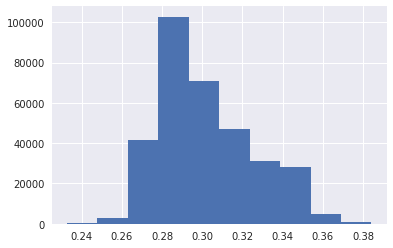

In [37]:
plt.hist(y_proba[:,2])

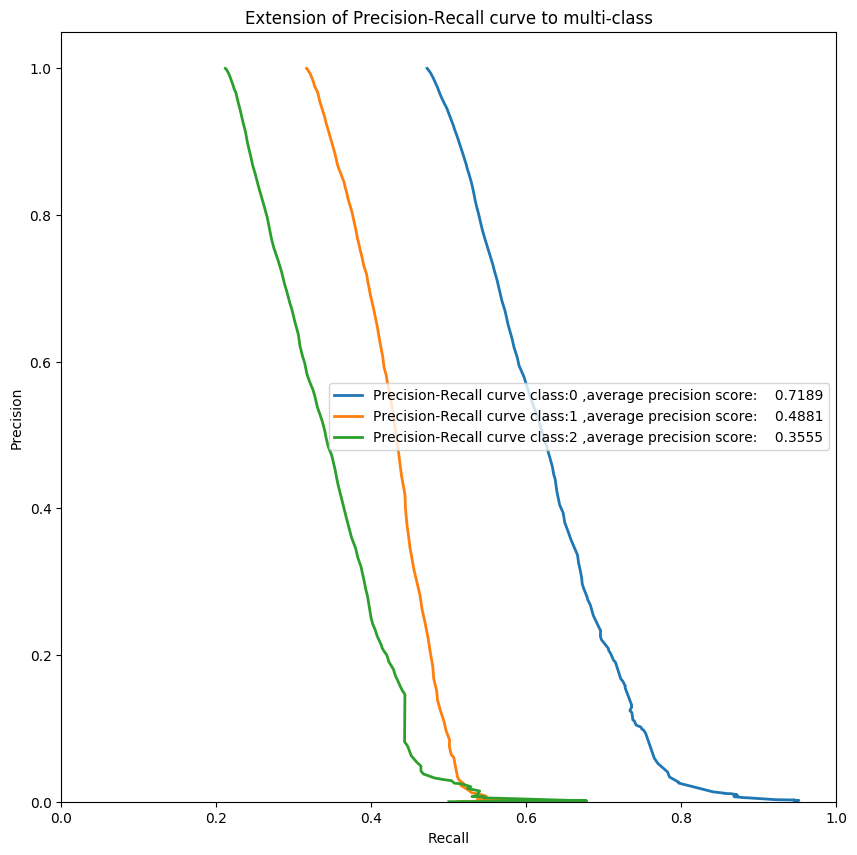

In [51]:
plt.figure(figsize = (10,10))
for i in range(y_test_2.shape[1]):
    asd= pr_curve(i,y_test_2.iloc[:,i],y_proba[:,i], digit_prec=3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="best")

In [39]:
(0.7019+0.5002 + 0.3850) / 3

0.5290333333333334

In [52]:
y_test_2.head()

,non_violent,property_,violent
490017,0.0,1.0,0.0
1722355,1.0,0.0,0.0
848123,0.0,1.0,0.0
987858,0.0,1.0,0.0
1935381,0.0,1.0,0.0


In [41]:
#thresholds for all crime times! prioritize crime...

In [42]:
#dollar for a dispatch ---save money with prioritize dispatch of police

In [53]:
np.sum(y_proba[:,0] > 0.4)

63293

In [54]:
y_test_2.head()

,non_violent,property_,violent
490017,0.0,1.0,0.0
1722355,1.0,0.0,0.0
848123,0.0,1.0,0.0
987858,0.0,1.0,0.0
1935381,0.0,1.0,0.0


In [55]:
pd.DataFrame(y_proba[1,:],objects)

,0
non_violent,0.382466
property,0.339236
violent,0.278298


In [56]:
y_prob_val[0]

array([ 0.27829844,  0.33923587,  0.38246569], dtype=float32)

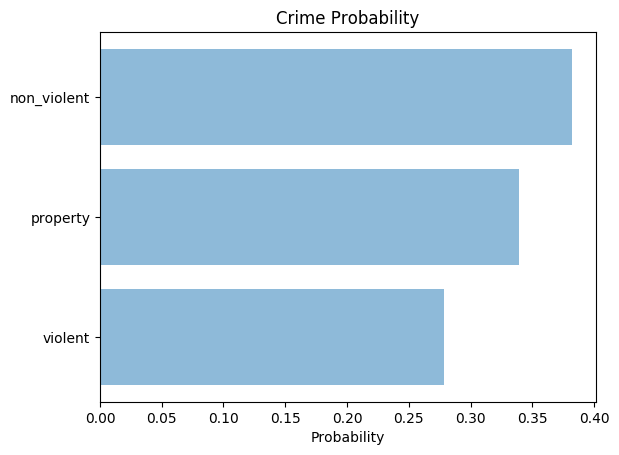

In [57]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('non_violent','property','violent')
sort_obj = pd.DataFrame(y_proba[1,:],objects).sort_values(by=0).T.columns
y_pos = np.arange(len(objects))
y_prob_val = pd.DataFrame(y_proba[1,:],objects).sort_values(by=0).T.values
plt.barh(y_pos, y_prob_val[0], align='center', alpha=0.5)
plt.yticks(y_pos, sort_obj)
plt.xlabel('Probability')
plt.title('Crime Probability')
plt.show()

In [58]:
sum(y_test_2['violent'])/y_test_2.shape[0]

0.21167779557059552

In [59]:
sum(y_test_2['non_violent'])/y_test_2.shape[0]

0.47196120494304622

In [60]:
sum(y_test_2['property_'])/y_test_2.shape[0]

0.31636099948635826

In [61]:
X_test.columns

Index(['X', 'Y', 'Hour', 'day'], dtype='object')

In [62]:
xgb.feature_importances_

array([ 0.42261374,  0.38897586,  0.15610693,  0.03230345], dtype=float32)

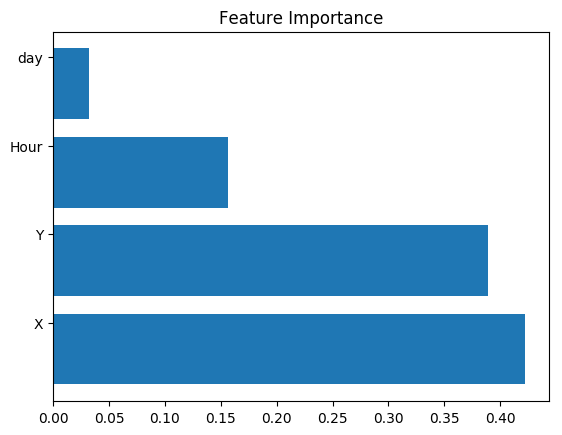

In [63]:
import ml_insights as mli
fig, ax = plt.subplots()
ind = np.array(range(len(X.columns)))+.7
plt.barh(ind,xgb.feature_importances_);
ax.set_yticks(ind + .3);
ax.set_yticklabels((X_test.columns))
plt.title('Feature Importance')

In [70]:
mxr = mli.ModelXRay(xgb,X_test.sample(1000))

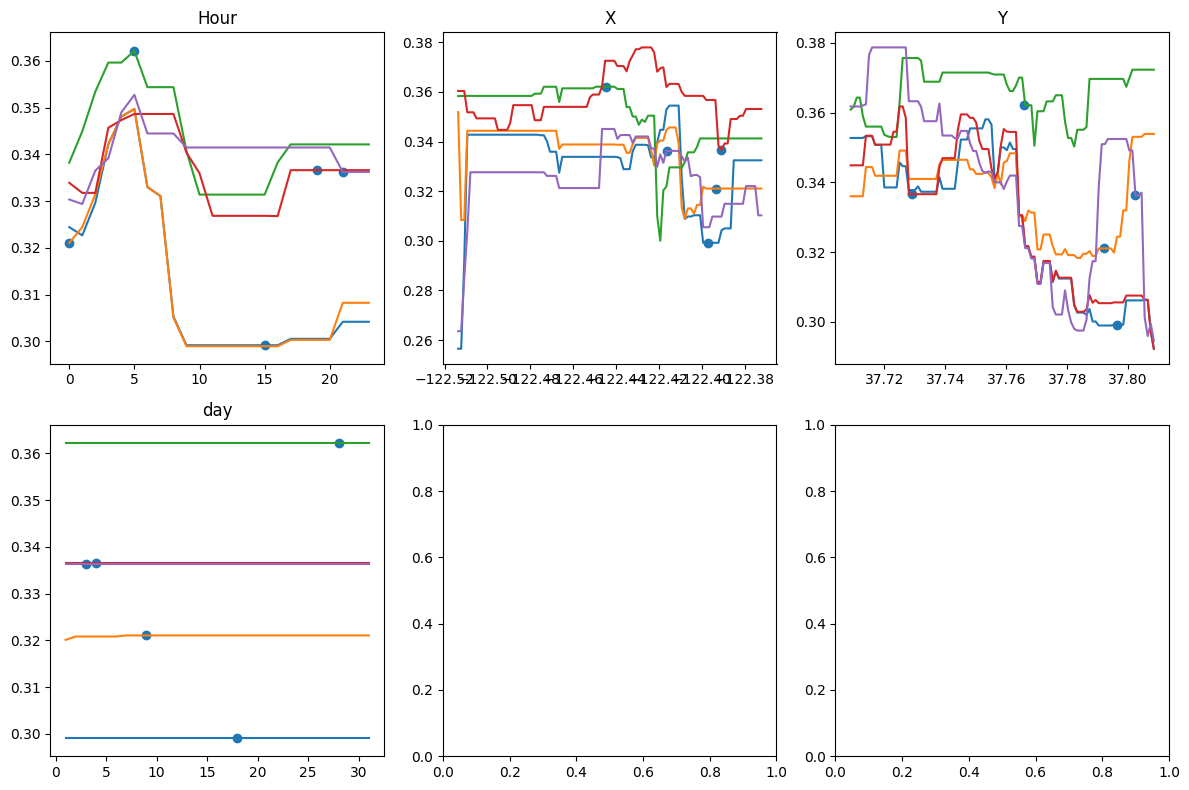

In [67]:
indices = mxr.feature_dependence_plots(num_pts=5, figsize = (20,20))

In [ ]:
pickle.load(open('crime_three_model.pkl'),'r')

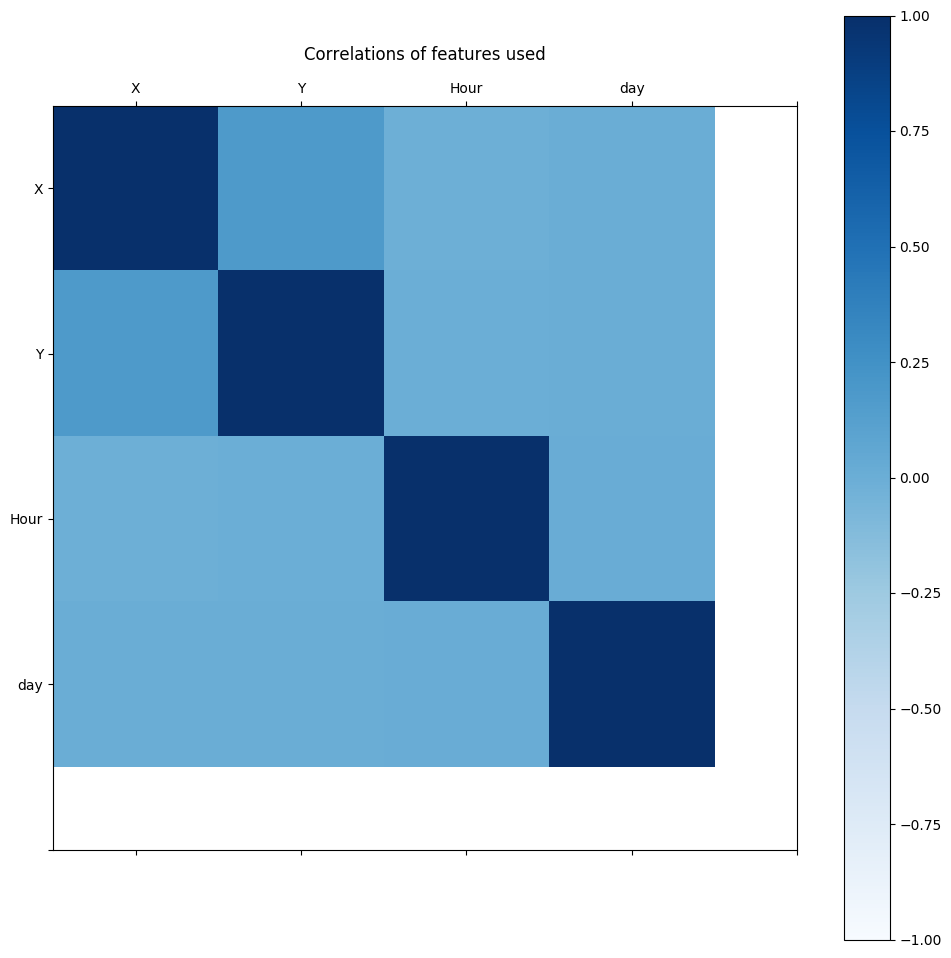

In [71]:
correlations = X.corr()
# plot correlation matrix
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1,cmap='Blues')
fig.colorbar(cax)
ticks = np.arange(0,5,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(X.columns)
ax.set_yticklabels(X.columns)
plt.title('Correlations of features used')
plt.show()

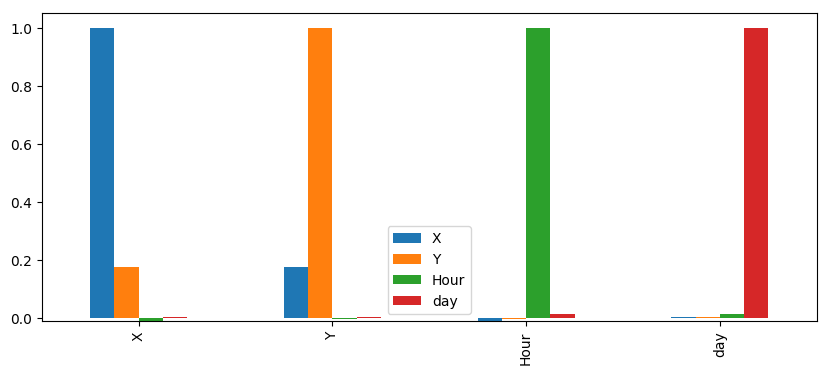

In [72]:
X.corr().plot(kind = 'bar',figsize=(10, 4))

In [73]:
three_data.groupby('X')['count'].sum().sort_values(ascending = False).idxmax()

-122.40340479147899

In [74]:
three_data.groupby('Y')['count'].sum().sort_values(ascending = False).idxmax()

37.775420706711003

In [75]:
X_user, Y_user,week_user,hour_user,day_user = -122.425892, 37.774599, 14, 23, 5

In [76]:
def check_user_sf(X_user,Y_user):
    X_limit_right = -122.35
    X_limit_left = -122.51
    Y_limit_top = 37.82
    Y_limit_bottom = 37.68
    if ((X_user  < X_limit_right) & (X_user> X_limit_left)& (Y_user < Y_limit_top) & (Y_user>Y_limit_bottom )):
        print('It looks like you\'re in San Francisco, unfortunately...')
        return True
    else:
        print('You\'re not in San Francisco!')
        return False

In [79]:
def plot_probs_user(X_user, Y_user,week_user,hour_user,day_user):
    #Plots the probability of a users crime--at
    import matplotlib.pyplot as plt; plt.rcdefaults()
    import numpy as np
    import matplotlib.pyplot as plt
    if check_user_sf(X_user,Y_user) == True:
        array_user = pd.Series(data=[X_user, Y_user,hour_user,day_user],index=['X', 'Y', 'Hour', 'day'])
        array_user=pd.DataFrame(array_user).T
        prob_user = xgb.predict_proba(array_user)
        objects = ('non_violent', 'property', 'violent')
        y_pos = np.arange(len(objects))
        plt.barh(y_pos, prob_user[0], align='center', alpha=0.5)
        plt.yticks(y_pos, objects)
        plt.xlabel('Probability')
        plt.title('Crime Probability')
        plt.show()
        return prob_user
    else:
        print('Try another location!')

In [80]:
def plot_probs_user(X_user, Y_user,day_user,hour_user):
    if check_user_sf(X_user,Y_user) == True:
        array_user = pd.Series(data=[X_user, Y_user,hour_user,day_user],index=['X', 'Y','Hour','day'])
        array_user=pd.DataFrame(array_user).T
        prob_user = xgb.predict_proba(array_user)
        objects = ('non_violent','property','violent')
        sort_obj = pd.DataFrame(prob_user[0],objects).sort_values(by=0).T.columns
        y_pos = np.arange(len(objects))
        y_prob_val = pd.DataFrame(prob_user[0],objects).sort_values(by=0).T.values
        plt.barh(y_pos, y_prob_val[0], align='center', alpha=0.5)
        plt.yticks(y_pos, sort_obj)
        plt.xlabel('Probability')
        plt.title('Crime Probability')
        plt.show()

It looks like you're in San Francisco, unfortunately...


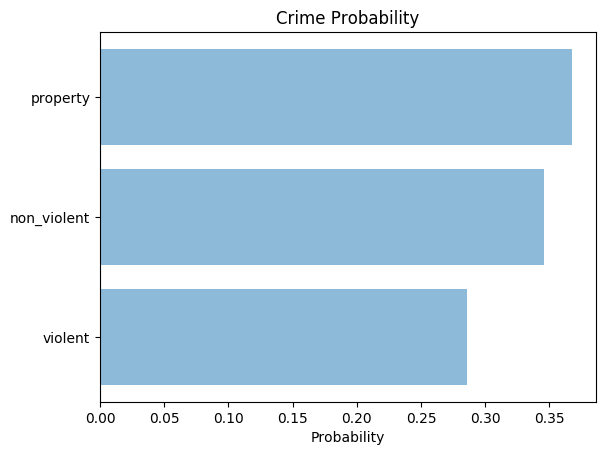

In [81]:
plot_probs_user(-122.425892, 37.745599, 14, 23)

In [121]:
plot_probs_user(-122.74, 33.75, 14, 23, 5)

TypeError: plot_probs_user() takes 3 positional arguments but 5 were given

## Plot crime data for that location over all time...?

## compare all probabilities to baseline!!!

## look at crime over the past years/weeks for when day = day_user, hour = hour_user, and the positions are known. So look at each possible crime.

In [34]:
y_test

490017       property_
1722355    non_violent
848123       property_
987858       property_
1935381      property_
1590854    non_violent
61644        property_
1823982    non_violent
557756     non_violent
297901       property_
1620931      property_
1973118        violent
1994121    non_violent
674655     non_violent
556671     non_violent
596815     non_violent
1986600    non_violent
540494         violent
1323411        violent
770880     non_violent
489766         violent
248078     non_violent
276034       property_
1343664    non_violent
1830417    non_violent
1302285      property_
1249323        violent
140311     non_violent
970674       property_
987157         violent
              ...     
450044       property_
1929974    non_violent
5376         property_
160784       property_
531390         violent
228106     non_violent
1159457    non_violent
1234892      property_
549078     non_violent
773695       property_
268215       property_
1038955    non_violent
658267     

In [ ]:
pickle.dump( xgb, open( "crime_model.pkl", "wb" ),protocol=2)

In [ ]:
crime_model = pickle.load( open( "crime_model.pkl", "rb" ))

In [69]:
set(train['Hour'])

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23}